In [1]:
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from Unet import *
from DiffusionModel import *

In [2]:
# define hyperparameters

image_size = 32
channel = 1

batchsize = 128

timestep = 1000
length = 100

lr = 1e-3
epochs = 5

dimmults = (1,2,4,8)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)

cuda:0


In [3]:
# get MNIST datasets

data_root = './data'

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
])

train_set = datasets.MNIST(
    root=data_root, train=True, download=True, transform=transform
)

data_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)

In [4]:
# define linear beta schedule

linear_betas, linear_alphas, linear_sqrt_alphas, linear_sqrt_one_minus_alphas, linear_sampling_1, linear_sampling_2 = total_beta_schedule(linear_beta_schedule, timestep)

# define linear network and optimizer_linear

linear_net = Unet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)
linear_net.to(device)

linear_optimizer = optim.Adam(linear_net.parameters(), lr=lr)

In [5]:
# train - linear

linear_training_loss, linear_training_taken_step, linear_taken_step = training(data_loader, epochs, timestep, linear_net, linear_optimizer, device, 
                                                                               linear_sqrt_alphas, linear_sqrt_one_minus_alphas)

>> epoch : 0
Loss:  0.04007720202207565
Loss:  0.031685393303632736
Loss:  0.02886287122964859
Loss:  0.021598584949970245
>> epoch : 1
Loss:  0.02492590993642807
Loss:  0.027342410758137703
Loss:  0.02181166782975197
Loss:  0.021510981023311615
Loss:  0.016171621158719063
>> epoch : 2
Loss:  0.01710011623799801
Loss:  0.022903883829712868
Loss:  0.014336164109408855
Loss:  0.015097481198608875
Loss:  0.024355577304959297
>> epoch : 3
Loss:  0.018562978133559227
Loss:  0.01602347381412983
Loss:  0.01989085227251053
Loss:  0.0206903163343668
>> epoch : 4
Loss:  0.015286476351320744
Loss:  0.020636949688196182
Loss:  0.019394956529140472
Loss:  0.01495193038135767
Loss:  0.015008094720542431


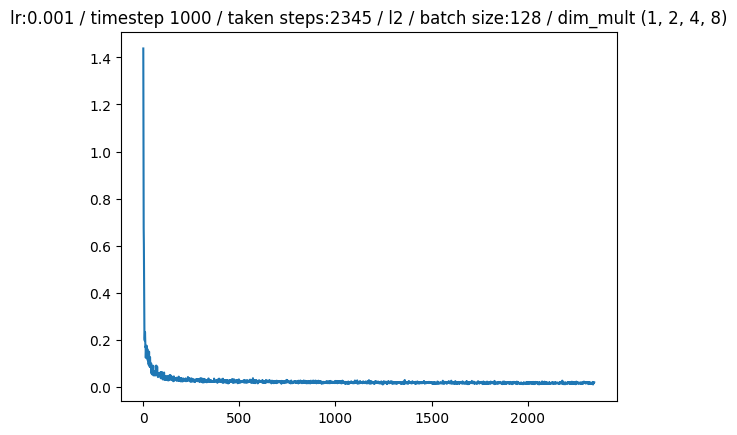

In [6]:
# plot loss linear 

x = np.array(linear_training_taken_step)
y = np.array([x.cpu().detach().numpy() for x in linear_training_loss])

plt.plot(x, y)
plt.title(f"lr:{lr} / timestep {timestep} / taken steps:{linear_taken_step} / l2 / batch size:{batchsize} / dim_mult {dimmults}")
plt.show()

In [7]:
# save linear model
save_net_betas(linear_net, linear_betas, linear_sampling_1, linear_sampling_2, "DDIM_model")